In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append('/Users/ap/workspace/Q0-sims')

import obs_tools as obs
import fg_tools as fg
import pk_tools as pk

In [20]:
# for plotting:
%matplotlib inline

font = {"size": 20, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = False

# Running PCA analysis including polarisation

In [3]:
# data:
data = pd.read_pickle('./Data/data.pkl')

HIsignal = data.nobeam.HI
HInoise = data.nobeam.noise
HI_fg_smooth = data.beam.foregrounds.sync + data.beam.foregrounds.psource + data.beam.foregrounds.free
HI_fg_pol_leak = data.nobeam.foregrounds.pleak

FGwpol_HI_noise_data = HIsignal+HInoise+HI_fg_smooth+HI_fg_pol_leak #data.beam.FGwpol_HI_noise
HI_noise_data = HIsignal + HInoise #data.beam.HI_noise

HI_noise_data_beam = data.beam.HI_noise

freqs = data.freqs

#### Perform PCA removal

In [4]:
pca_res_2 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=2)[0]

pca_res_4 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=4)[0]
pca_res_5 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=5)[0]

pca_res_6 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=6)[0]
pca_res_7 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=7)[0]

pca_res_10 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=10)[0]

#### Sims specs

In [5]:
# Dimension of data cube:
lx, ly, lz = 1000,1000, 924.78 #Mpc/h
nx, ny, nz = 256, 256, 285
# weighting and window function:
w = W = np.ones((nx,ny,nz))

# minimum and maximum k in each direction:
kmin, kmin_perp, kmin_par = 2*np.pi/pow(lx*ly*lz, 1/3), 2*np.pi/np.sqrt(lx**2 + ly**2), 2*np.pi/lz
kmax, kmax_par, kmax_perp = 0.4, 0.4, 0.4

# set width of k bins to be 2*kmin
dk, dk_perp, dk_par = 2*kmin, 2*kmin_perp, 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_perp = int((kmax_perp-kmin_perp)/dk_perp)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_perp = np.arange(kmin_perp,kmax_perp,dk_perp)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
kperp = np.linspace(kmin_perp+0.5*dk_perp,kmax_perp-0.5*dk_perp,nkbin_perp)
kpar = np.linspace(kmin_par+0.5*dk_par,kmax_par-0.5*dk_par,nkbin_par)

#### Calculate 3D Pk

In [6]:
# true HI power spectrum:
HI_pk = pk.getpk(HI_noise_data, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

# true HI power spectrum with beam:
HI_pk_beam = pk.getpk(HI_noise_data_beam, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

# residual power spectrum from PCA:
PCA2_pk = pk.getpk(pca_res_2, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA4_pk = pk.getpk(pca_res_4, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA5_pk = pk.getpk(pca_res_5, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA6_pk = pk.getpk(pca_res_6, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA7_pk = pk.getpk(pca_res_7, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

PCA10_pk = pk.getpk(pca_res_10, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

#### Calculate multipoles and Q0

In [28]:
P0 = pk.getpkmultipoles(HI_noise_data, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
P2 = pk.getpkmultipoles(HI_noise_data, w, W, nx, ny, nz, lx, ly, lz, kbins)[1]
P4 = pk.getpkmultipoles(HI_noise_data, w, W, nx, ny, nz, lx, ly, lz, kbins)[2]

Q0 = P0 -(1/2.)*P2 + (3/8.)*P4
Q2 = (3/4.)*(2*P2-5*P4)

In [36]:
#Q2

In [29]:
PCA4_P0 = pk.getpkmultipoles(pca_res_4, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA4_P2 = pk.getpkmultipoles(pca_res_4, w, W, nx, ny, nz, lx, ly, lz, kbins)[1]
PCA4_P4 = pk.getpkmultipoles(pca_res_4, w, W, nx, ny, nz, lx, ly, lz, kbins)[2]

PCA4_Q0 = PCA4_P0 -(1/2.)*PCA4_P2 + (3/8.)*PCA4_P4
PCA4_Q2 = (3/4.)*(2*PCA4_P2-5*PCA4_P4)


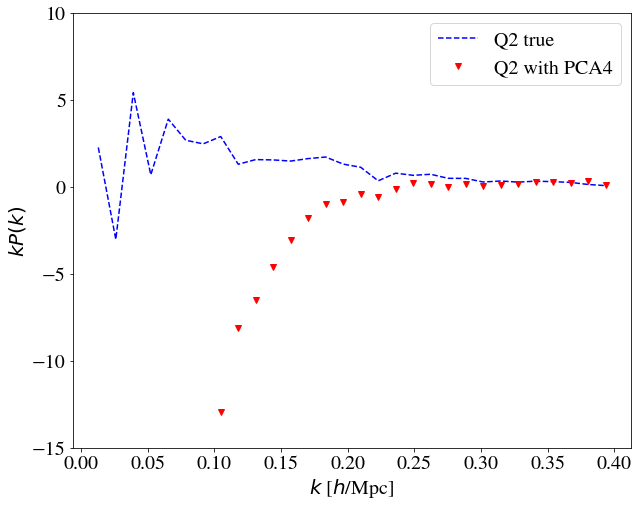

In [34]:
fig = plt.figure(figsize=(10,8))

plt.plot(k, k*Q2, ls='--', marker='', c='blue', label = r'Q2 true')

plt.plot(k, k*PCA4_Q2, ls='', marker='v', c='red', label = r'Q2 with PCA4')

plt.xlabel('$k$ [$h$/Mpc]', fontsize=20)
plt.ylabel('$k P(k)$', fontsize=20)

plt.ylim(-15,10)

plt.legend()

plt.show()

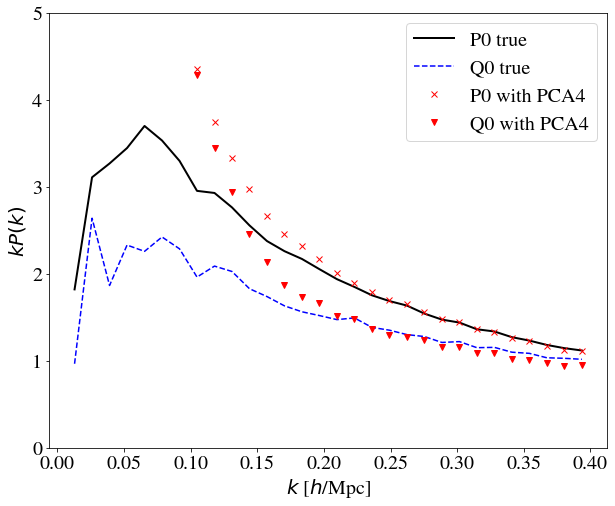

In [27]:
fig = plt.figure(figsize=(10,8))

#plt.plot(k, k*HI_pk_beam, ls='--', c='k', lw=2, label = r'HI + noise data, with beam')
plt.plot(k, k*HI_pk, ls='solid', c='k', lw=2, label = r'P0 true')
#plt.plot(k, k*P0, ls='', marker='o', c='b', label = r'P0 true')
#plt.plot(k, k*P2, ls='', marker='x', c='r', label = r'P2 true')
#plt.plot(k, k*P4, ls='', marker='v', c='g', label = r'P4 true')
plt.plot(k, k*Q0, ls='--', marker='', c='blue', label = r'Q0 true')

plt.plot(k, k*PCA4_P0, ls='', marker='x', c='red', label = r'P0 with PCA4')
plt.plot(k, k*PCA4_Q0, ls='', marker='v', c='red', label = r'Q0 with PCA4')

plt.xlabel('$k$ [$h$/Mpc]', fontsize=20)
plt.ylabel('$k P(k)$', fontsize=20)

plt.ylim(0,5)

plt.legend()

plt.show()

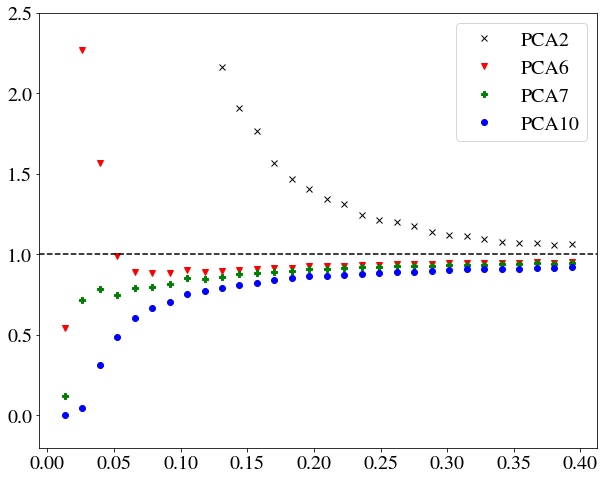

In [24]:
fig = plt.figure(figsize=(10,8))

plt.plot(k, PCA2_pk/HI_pk, marker='x', ls='', c='black', lw=4, label='PCA2')
#plt.plot(k, PCA5_pk/HI_pk, marker='x',ls='', c='m', lw=4, label='PCA5')
plt.plot(k, PCA6_pk/HI_pk, marker='v',ls='', c='r', lw=4, label='PCA6')
plt.plot(k, PCA7_pk/HI_pk, marker='P',ls='', c='green', lw=4, label='PCA7')

plt.plot(k, PCA10_pk/HI_pk, marker='o',ls='', c='b', lw=4, label='PCA10')


plt.axhline(y=1., color='black', linestyle='--')

plt.ylim(-0.2,2.5)

plt.legend()

plt.show()

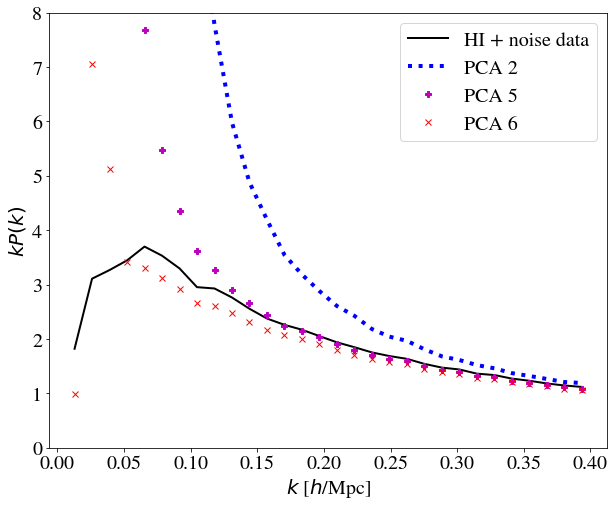

In [25]:
fig = plt.figure(figsize=(10,8))

#plt.plot(k, k*HI_pk_beam, ls='--', c='k', lw=2, label = r'HI + noise data, with beam')
plt.plot(k, k*HI_pk, ls='solid', c='k', lw=2, label = r'HI + noise data')

plt.plot(k, k*PCA2_pk, ls='dotted',c='b', lw=4, label = r'PCA 2')
plt.plot(k, k*PCA5_pk, marker='P', ls='',c='m', lw=4, label = r'PCA 5')

plt.plot(k, k*PCA6_pk, marker='x',ls='',c='r', lw=4, label = r'PCA 6')

plt.xlabel('$k$ [$h$/Mpc]', fontsize=20)
plt.ylabel('$k P(k)$', fontsize=20)

plt.ylim(0,8)

plt.legend()

plt.show()

#### Calculate 1D P($k_\parallel$)

In [ ]:
# true HI power spectrum:
HI_pk_para = pk.ParaPk(HI_noise_data, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]

# residual power spectrum from PCA:
PCA7_pk_para = pk.ParaPk(pca_res_7, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA6_pk_para = pk.ParaPk(pca_res_6, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]

Calculate 1D P($k_\perp$)

In [ ]:
# true HI power spectrum:
HI_pk_perp = pk.PerpPk(HI_noise_data, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

# residual power spectrum from PCA:
PCA7_pk_perp = pk.PerpPk(pca_res_7, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
PCA6_pk_perp = pk.PerpPk(pca_res_6, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

In [ ]:
fig, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(nrows=2, ncols=3, sharex='col', 
                                                       figsize=(19,9), gridspec_kw={'height_ratios': [3, 1.7]})
fig.subplots_adjust(hspace=0, wspace=0.24)

ax1.plot(k, (k*k*k*HI_pk)/(2*np.pi*np.pi), ls='solid', c='k', lw=6, label = r'HI + noise data')
#ax1.plot(k, (k*k*k*GPR_pk_bias)/(2*np.pi*np.pi), ls='solid', c='limegreen', lw=2)
ax1.plot(k, (k*k*k*PCA7_pk)/(2*np.pi*np.pi), ls='dotted',c='b', lw=4)
ax1.plot(k, (k*k*k*PCA6_pk)/(2*np.pi*np.pi), ls='dashdot',c='r', lw=4)
#ax1.plot(k, (k*k*k*GPR_pk)/(2*np.pi*np.pi), ls='dashed', c='limegreen', lw=5, label = r'GPR clean')
ax1.text(k[0]*7.4, 0.000095, r'$k = 0.09 \, h$/Mpc', c='hotpink')
ax1.axvline(k[6], c='hotpink')
ax1.set_xscale('log')
ax1.set_ylim(0,0.0005)
ax1.set_ylabel('$\Delta^2 (k)$ [mK$^2$]', fontsize=20)

ax2.scatter(k, 100*(PCA7_pk - HI_pk)/HI_pk, marker='s', s=60, edgecolor='b', facecolor='none', lw=2)
ax2.scatter(k, 100*(PCA6_pk - HI_pk)/HI_pk, marker='v', s=90, edgecolor='r', facecolor='none', lw=2)
#ax2.scatter(k, 100*(GPR_pk - HI_pk)/HI_pk, s=90, marker='o', edgecolor='limegreen', facecolor='none', lw=2, label = r'GPR clean')
ax2.set_ylim(-10,9)
ax2.axvline(k[6], c='hotpink')
ax2.axhline(0, c='k', lw=3)
ax2.set_xscale('log')
ax2.set_xlabel('$k$ [$h$/Mpc]', fontsize=20)
ax2.set_ylabel('\% residual', fontsize=20)

ax3.plot(kpar, kpar*HI_pk_para, ls='solid', c='k', lw=6)
#ax3.plot(kpar, kpar*GPR_pk_para_bias, ls='solid', c='limegreen', lw=2, label = r'GPR clean, bias corrected')
ax3.plot(kpar, kpar*PCA7_pk_para, ls='dotted',c='b', lw=4, label = r'PCA clean $N_{\rm FG} = 7$')
ax3.plot(kpar, kpar*PCA6_pk_para, ls='dashdot',c='r', lw=4)
#ax3.plot(kpar, kpar*GPR_pk_para, ls='dashed', c='limegreen', lw=5)
ax3.text(k[0]*2.2, 0.0041, r'$k_\parallel = 0.03 \, h$/Mpc', c='hotpink')
ax3.axvline(kpar[1], c='hotpink')
ax3.set_xscale('log')
ax3.set_ylabel('$k_\parallel P(k_\parallel)$ [mK$^2$]', fontsize=20)

ax4.scatter(kpar, 100*(PCA7_pk_para - HI_pk_para)/HI_pk_para, marker='s', s=60, edgecolor='b', facecolor='none', lw=2)
ax4.scatter(kpar, 100*(PCA6_pk_para - HI_pk_para)/HI_pk_para, marker='v', s=90, edgecolor='r', facecolor='none', lw=2)
#ax4.scatter(kpar, 100*(GPR_pk_para - HI_pk_para)/HI_pk_para, s=90, marker='o', edgecolor='limegreen', facecolor='none', lw=2)
ax4.axvline(kpar[1], c='hotpink')
ax4.set_ylim(-10,10)
ax4.set_xscale('log')
ax4.set_xlabel('$k_\parallel$ [$h$/Mpc]', fontsize=20)
ax4.set_ylabel('\% residual', fontsize=20)
ax4.axhline(0, c='k', lw=3)

ax5.plot(kperp, kperp*kperp*HI_pk_perp, ls='solid', c='k', lw=6)
ax5.plot(kperp, kperp*kperp*PCA7_pk_perp, ls='dotted',c='b', lw=4)
ax5.plot(kperp, kperp*kperp*PCA6_pk_perp, ls='dashdot',c='r', lw=4, label = r'PCA clean $N_{\rm FG} = 6$')
#ax5.plot(kperp, kperp*kperp*GPR_pk_perp, ls='dashed', c='limegreen', lw=5)
ax5.set_xscale('log')
ax5.set_ylabel('$k_\perp^2 P(k_\perp)$ [mK$^2$]', fontsize=20)

ax6.scatter(kperp, 100*(PCA7_pk_perp - HI_pk_perp)/HI_pk_perp, marker='s', s=60, edgecolor='b', facecolor='none', lw=2, label = r'PCA clean $N_{\rm FG} = 7$')
ax6.scatter(kperp, 100*(PCA6_pk_perp - HI_pk_perp)/HI_pk_perp, marker='v', s=90, edgecolor='r', facecolor='none', lw=2, label = r'PCA clean $N_{\rm FG} = 6$')
#ax6.scatter(kperp, 100*(GPR_pk_perp - HI_pk_perp)/HI_pk_perp, s=90, marker='o', edgecolor='limegreen', facecolor='none', lw=2)
ax6.set_ylim(-10,10)
ax6.set_xlabel('$k_\perp$ [$h$/Mpc]', fontsize=20)
ax6.set_ylabel('\% residual', fontsize=20)
ax6.axhline(0, c='k', lw=3)

fig.legend(bbox_to_anchor=(0.11, 0.88, 0.8, 0), loc="lower left", mode="expand", ncol=4, fontsize=20)

#plt.savefig('figs/pk_all_wpol', dpi=300, bbox_inches="tight")

plt.show()